Final Project Title: Oil Price Forecast using ARIMA, LSTM, and N-HITS

Name: HJ Kim 

Class: MAP6114

Blog: https://github.com/pangsoo/final_6114

In [1]:
#Required libraries
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
import math
import time
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00


In [2]:
# Data link

url = "https://raw.githubusercontent.com/pangsoo/final_6114/main/finaldata.csv"
df = pd.read_csv(url)
df

,date,dji,eur,10yr_R,eu_money,us_money,ip,coal,nok,usd-nok,wti,ip_yoy,dji_yoy,eu_money_yoy,us_money_yoy
0,Jan-11,"11,891.93",1.3686,3.374,1113,2047.9,93.3944,129.40,5.7770,0.173100,92.19,0.047127,0.181240,-0.036364,0.026516
1,Feb-11,"12,226.34",1.3802,3.422,1075,2211.6,92.9930,130.95,5.5991,0.178600,96.97,0.039060,0.184119,-0.075666,0.045575
2,Mar-11,"12,319.73",1.4165,3.470,1061,2395.3,93.9820,123.20,5.5355,0.180652,106.72,0.042601,0.134766,-0.103128,0.151808
3,Apr-11,"12,810.54",1.4799,3.290,1058,2496.6,93.6525,122.80,5.2466,0.190600,113.93,0.035302,0.163684,-0.122720,0.239376
4,May-11,"12,569.79",1.4394,3.059,1066,2567.2,93.7775,120.95,5.3780,0.185943,102.70,0.022633,0.240036,-0.131214,0.275754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Nov-22,"34,587.46",1.0405,3.611,6386,5418.7,103.0719,397.00,9.8382,0.101645,80.56,0.018526,0.003008,0.055188,-0.152626
143,Dec-22,"33,147.28",1.0702,3.879,6296,5405.4,101.4761,404.15,9.7965,0.102077,80.47,0.005849,-0.087814,0.030442,-0.157131
144,Jan-23,"34,086.89",1.0861,3.510,6054,5328.4,102.4257,251.75,9.9789,0.100154,80.11,0.013888,-0.029744,-0.007215,-0.127050
145,Feb-23,"32,654.98",1.0576,3.928,5813,5321.0,102.6390,192.85,10.3772,0.096365,77.05,0.009465,-0.036516,-0.045014,-0.119025


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          147 non-null    object 
 1   dji           147 non-null    object 
 2   eur           147 non-null    float64
 3   10yr_R        147 non-null    float64
 4   eu_money      147 non-null    int64  
 5   us_money      147 non-null    float64
 6   ip            147 non-null    float64
 7   coal          147 non-null    float64
 8   nok           147 non-null    float64
 9   usd-nok       147 non-null    float64
 10  wti           147 non-null    float64
 11  ip_yoy        147 non-null    float64
 12  dji_yoy       147 non-null    float64
 13  eu_money_yoy  147 non-null    float64
 14  us_money_yoy  147 non-null    float64
dtypes: float64(12), int64(1), object(2)
memory usage: 17.4+ KB


In [4]:
# Convert to time-series 
df['date'] = pd.to_datetime(df['date'], format = '%b-%y')
df.set_index('date', inplace=True)

# Change object to float64 number
df['dji'] = df['dji'].str.replace(',', '').astype(float)
df.head()

,dji,eur,10yr_R,eu_money,us_money,ip,coal,nok,usd-nok,wti,ip_yoy,dji_yoy,eu_money_yoy,us_money_yoy
date,,,,,,,,,,,,,,
2011-01-01,11891.93,1.3686,3.374,1113,2047.9,93.3944,129.40,5.7770,0.173100,92.19,0.047127,0.181240,-0.036364,0.026516
2011-02-01,12226.34,1.3802,3.422,1075,2211.6,92.9930,130.95,5.5991,0.178600,96.97,0.039060,0.184119,-0.075666,0.045575
2011-03-01,12319.73,1.4165,3.470,1061,2395.3,93.9820,123.20,5.5355,0.180652,106.72,0.042601,0.134766,-0.103128,0.151808
2011-04-01,12810.54,1.4799,3.290,1058,2496.6,93.6525,122.80,5.2466,0.190600,113.93,0.035302,0.163684,-0.122720,0.239376
2011-05-01,12569.79,1.4394,3.059,1066,2567.2,93.7775,120.95,5.3780,0.185943,102.70,0.022633,0.240036,-0.131214,0.275754


In [68]:
wti = df.iloc[:, [9]]
wti.tail()

,wti
date,
2022-11-01,80.56
2022-12-01,80.47
2023-01-01,80.11
2023-02-01,77.05
2023-03-01,75.67


## 1. ARIMA 

ARIMA - EDA

In [69]:
# ADF Check

from statsmodels.tsa.stattools import adfuller

wti_diff1 = wti.diff().dropna()['wti']
result = adfuller(wti)

print(f'Original ADF Stat: {result[0]: .3f}')
print(f'Original p-value: {result[1]: .3f}')

result = adfuller(wti_diff1)
print(f'1st Diff ADF Stat: {result[0]: .3f}')
print(f'ast Diff p-value: {result[1]: .3f}') # P-Value indicating 1st differential is stationary

Original ADF Stat: -2.192
Original p-value:  0.209
1st Diff ADF Stat: -10.291
ast Diff p-value:  0.000


<Axes: xlabel='date'>

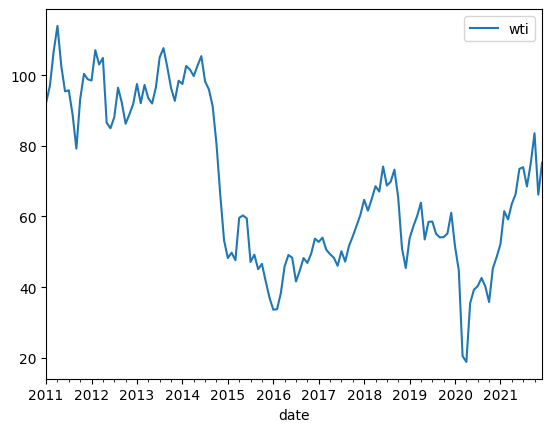

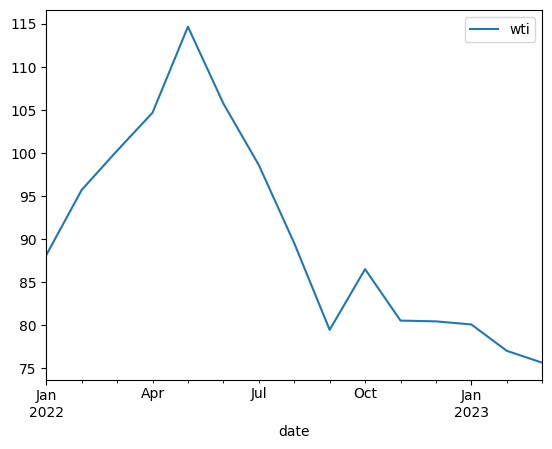

In [70]:
from pmdarima.arima import ndiffs
import pmdarima as pm

wti_train = wti[:int(0.9*len(wti))]
wti_test = wti[int(0.9*len(wti)):]
wti_train.plot()
wti_test.plot()

In [71]:
print(wti_train.shape)
wti_test.head()

(132, 1)


,wti
date,
2022-01-01,88.15
2022-02-01,95.72
2022-03-01,100.28
2022-04-01,104.69
2022-05-01,114.67


In [72]:
# m = 1
model = pm.auto_arima(y = wti_train, 
                      d=1, 
                      start_p = 0,
                      max_p = 3,
                      start_q = 0,
                      max_q = 3,
                      m = 1,
                      seasonal = False,
                      stepwise = True,
                      trace = True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=866.149, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=866.515, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=866.248, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=864.201, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=868.083, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds


In [73]:
# m = 12 
model = pm.auto_arima(y = wti_train, 
                      d=1, 
                      start_p = 0,
                      max_p = 12,
                      start_q = 0,
                      max_q = 12,
                      m = 12,
                      seasonal = True,
                      stepwise = True,
                      trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=866.149, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=868.451, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=868.154, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=864.201, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=868.119, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=868.108, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=866.515, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=866.248, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=868.083, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.514 seconds


Best model = (0, 1, 0) regardless of m = 1 or 12

In [74]:
model = ARIMA(wti_train, order = (0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    wti   No. Observations:                  132
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -431.100
Date:                Fri, 05 May 2023   AIC                            864.201
Time:                        15:08:16   BIC                            867.076
Sample:                    01-01-2011   HQIC                           865.369
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        42.2586      4.099     10.308      0.000      34.224      50.293
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):                17.09
Prob(Q):                              0.20   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


* Result: p-value of Ljung-Box equals to 0.20 and JP 0.16 meaning the model does not have any autocorrelation and not Gaussian normally distributed

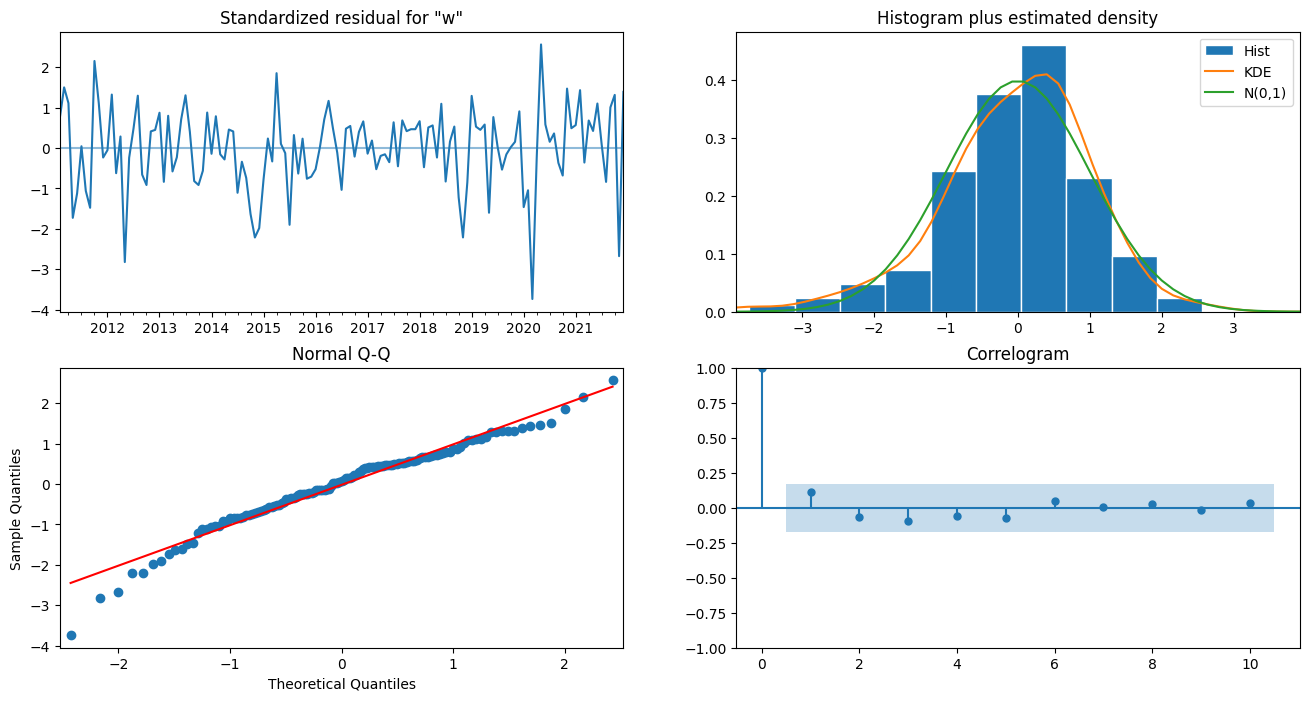

In [75]:
model_fit.plot_diagnostics(figsize = (16, 8))
plt.show()

<ipython-input-76-c2e1d6ab12a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti['forecast']=model_fit.forecast(steps = len(wti_test))


<Axes: xlabel='date'>

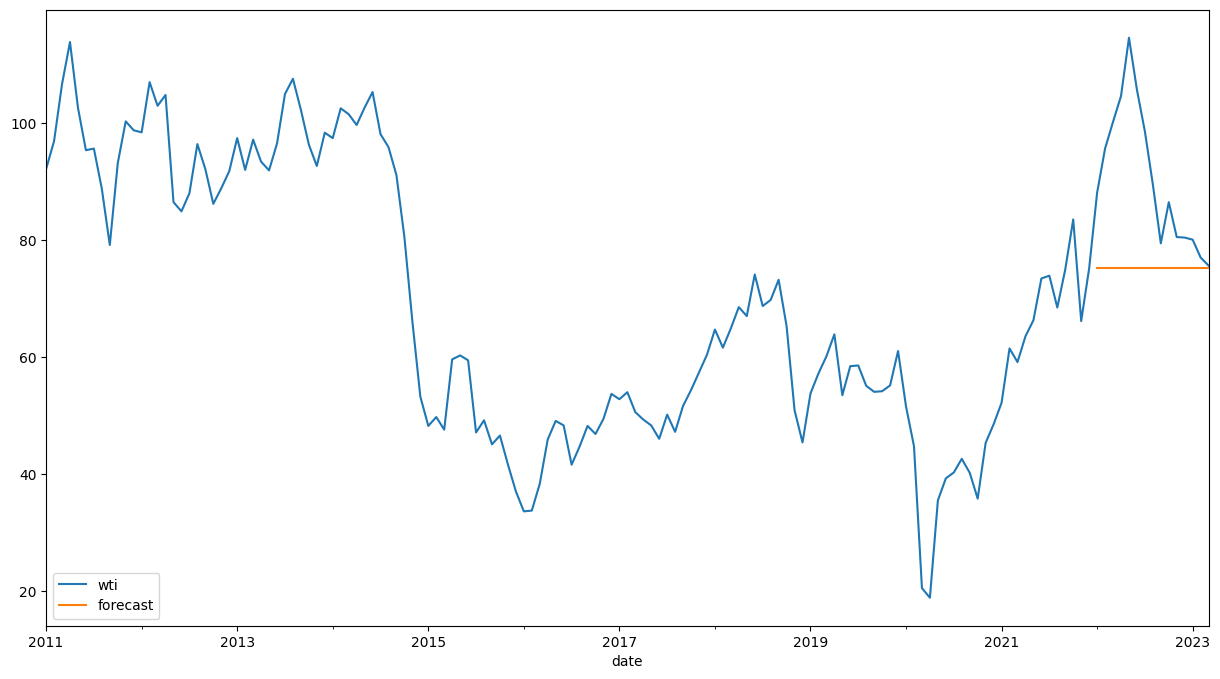

In [76]:
wti['forecast']=model_fit.forecast(steps = len(wti_test))
wti[['wti', 'forecast']].plot(figsize=(15, 8))

Performance: The accuracy reads at 84.5% which is quite good score but it only stays flat till the end

In [82]:
# Performance
mape_arima = np.mean(np.abs(wti['forecast'] - wti['wti'])/np.abs(wti['wti']))
print('MAPE: '+str(mape_arima))
accuracy = 1- mape_arima
print('Accuracy: '+str(accuracy))

MAPE: 0.15538100820143833
Accuracy: 0.8446189917985617


## **2. LSTM (Multivariate)**

2-1) Preprocessing: Min Max Scaler

In [ ]:
!pip install seaborn
!pip install tensor
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [6]:
# Setting Target 

target_list = ['wti', 'eur']
target = target_list[0]

lag = 15
WINDOW_SIZE= 15  # reading 6mo in order to forecast 6mo 

def make_dataset(data, label, window_size = WINDOW_SIZE):
  feature_list = []
  label_list = []
  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list), np.array(label_list)

In [7]:
# Min Max Scaler

scaler = MinMaxScaler()
mini = min(df[target])
maxi = max(df[target])
scale = maxi - mini

scaled = scaler.fit_transform(df)
columns = df.columns
df_scaled = pd.DataFrame(scaled, columns = columns)
df_scaled.tail()

,dji,eur,10yr_R,eu_money,us_money,ip,coal,nok,usd-nok,wti,ip_yoy,dji_yoy,eu_money_yoy,us_money_yoy
142,0.931137,0.1212,0.875178,1.000000,0.772198,0.946404,0.904651,0.814764,0.098784,0.644057,0.571521,0.239139,0.348537,0.006053
143,0.874492,0.1806,0.951379,0.983108,0.769151,0.864653,0.923227,0.807364,0.103168,0.643118,0.533618,0.101433,0.322977,0.000000
144,0.911449,0.2124,0.846460,0.937688,0.751512,0.913300,0.527280,0.839730,0.083685,0.639361,0.557653,0.189479,0.284082,0.040419
145,0.855130,0.1554,0.965311,0.892455,0.749817,0.924227,0.374253,0.910407,0.045297,0.607430,0.544430,0.179212,0.245041,0.051201
146,0.879441,0.2080,0.835940,0.899024,0.807088,0.944043,0.333723,0.925064,0.037587,0.593029,0.532112,0.173137,0.233366,0.087724


Text(0, 0.5, 'index')

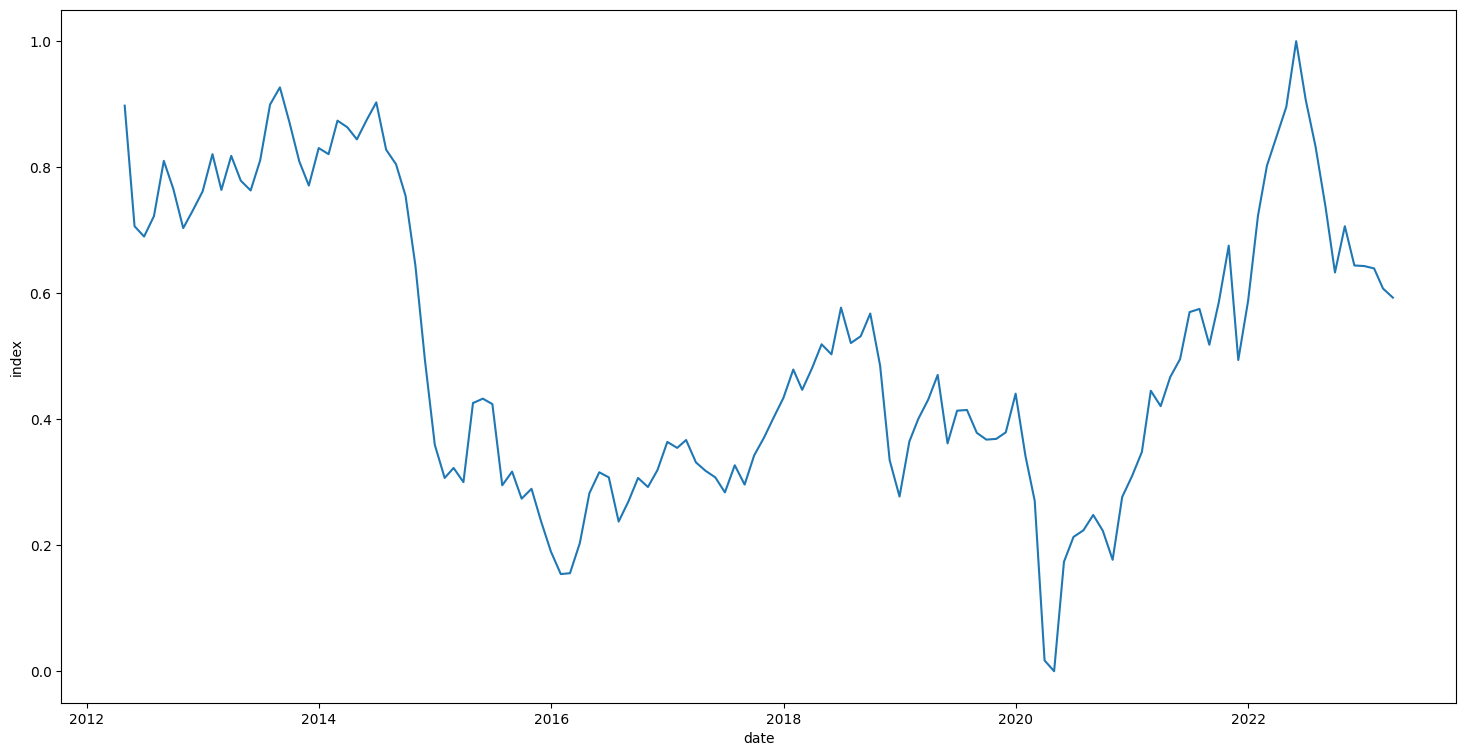

In [8]:
y = df_scaled.loc[:, df_scaled.columns == target][lag:]
x = df_scaled.loc[:, df_scaled.columns != target][:-lag]
test = df_scaled.loc[:, df_scaled.columns != target][-(lag + WINDOW_SIZE):]

rng = pd.date_range('2012-04-01', periods = len(y), freq = 'M')
y.index = rng
x.index = rng
df_scaled = pd.concat([y, x], axis = 1)

plt.figure(figsize = (18, 9))
sns.lineplot(y = df_scaled[target], x = df_scaled.index)
plt.xlabel('date')
plt.ylabel('index')

In [9]:
n_train = int(len(df_scaled) * 0.9)

train = df_scaled

n_train

118

In [10]:
# Train Test Split

ffeature_cols = x.columns
label_cols = y.columns

train_feature = x
train_label = y

train_feature, train_label = make_dataset(train_feature, train_label, 15)
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = len(test))
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((87, 15, 13), (30, 15, 13), (87, 1), (30, 1))

In [11]:
print(np.shape(train))
print(np.shape(test))

(132, 14)
(30, 13)


In [12]:
test_feature = test
test_label = pd.DataFrame([np.nan] * len(test_feature))

test_feature.shape, test_label.shape

((30, 13), (30, 1))

In [13]:
test_feature, test_label = make_dataset(test_feature, test_label, 15)
test_feature.shape, test_label.shape

((15, 15, 13), (15, 1))

2-2) Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda,Dropout, Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, activation='tanh', input_shape = (train_feature.shape[1], train_feature.shape[2])))
model.add(LSTM(units=64, return_sequences=True, activation='tanh'))
model.add(LSTM(units=32, activation = 'tanh'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 256)           276480    
                                                                 
 lstm_1 (LSTM)               (None, 15, 64)            82176     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 371,105
Trainable params: 371,105
Non-trainable params: 0
_________________________________________________________________


In [15]:
# USing Huber to score the performance for Sequence

loss = Huber()
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
model.compile(loss=Huber(), optimizer = optimizer, metrics = ['mae'])

In [16]:
# Stop learning if val_loss is not improved any further with earlystopping

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10)

# Checkpointer created on val_loss

filename = os.path.join('tmp', 'checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only = True,
                             save_best_only = True,
                             monitor = 'val_loss',
                             verbose = 1)

In [17]:
history = model.fit(x_train, y_train,
                    validation_data = (x_valid, y_valid),
                    epochs = 20,
                    callbacks = [checkpoint, earlystopping])

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.1201 - mae: 0.4371
Epoch 1: val_loss improved from inf to 0.03087, saving model to tmp/checkpointer.ckpt
3/3 [==============================] - 8s 801ms/step - loss: 0.1201 - mae: 0.4371 - val_loss: 0.0309 - val_mae: 0.1762
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.0359 - mae: 0.2129
Epoch 2: val_loss did not improve from 0.03087
3/3 [==============================] - 0s 99ms/step - loss: 0.0359 - mae: 0.2129 - val_loss: 0.0634 - val_mae: 0.3170
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.0634 - mae: 0.3124
Epoch 3: val_loss did not improve from 0.03087
3/3 [==============================] - 0s 97ms/step - loss: 0.0634 - mae: 0.3124 - val_loss: 0.0727 - val_mae: 0.3376
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.0503 - mae: 0.2777
Epoch 4: val_loss improved from 0.03087 to 0.02682, saving model to tmp/checkpointer.ckpt
3/3 [======================

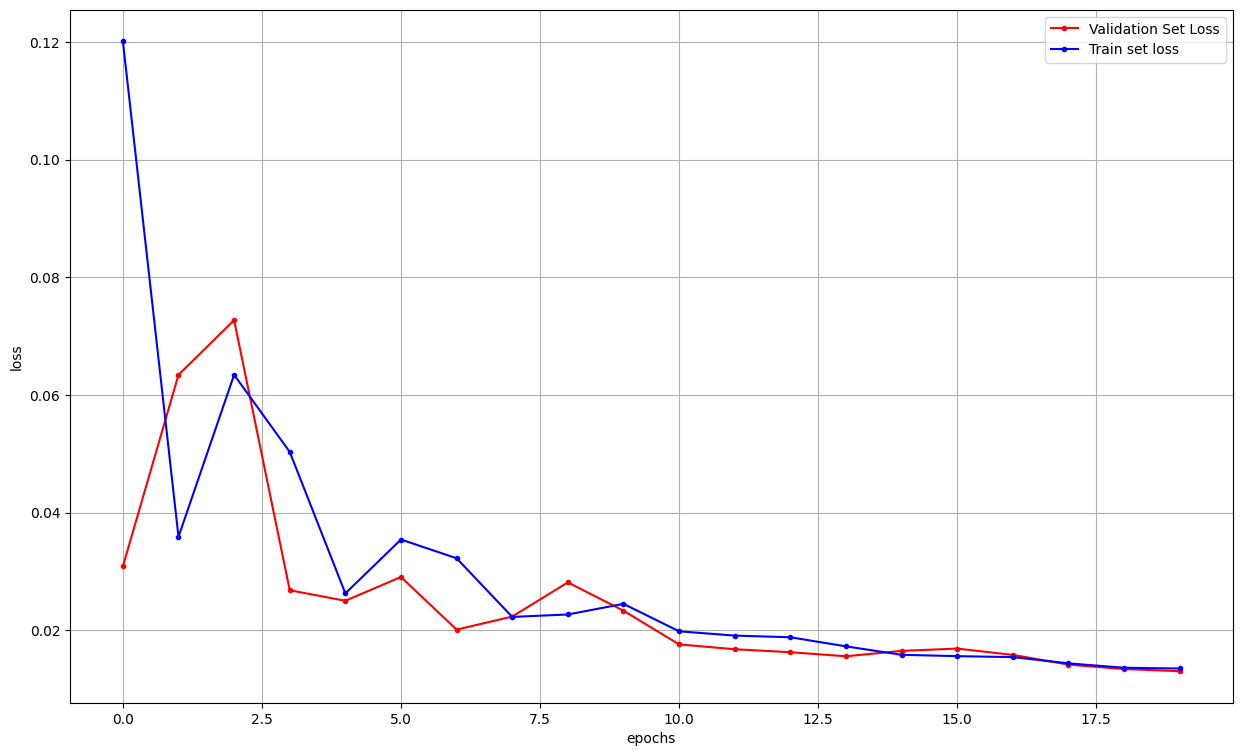

In [18]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.figure(figsize = (15, 9))
plt.plot(x_len, y_vloss, marker = '.', c = 'red', label = 'Validation Set Loss')
plt.plot(x_len, y_loss, marker = '.', c = 'blue', label = 'Train set loss')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [19]:
# Prediction

pred = model.predict(test_feature)

1/1 [==============================] - 2s 2s/step


In [20]:
empty = np.empty((len(y)-1, 1))
empty[:] = np.nan

df_new = pd.DataFrame(scaler.inverse_transform(scaled), columns = columns)
y = df_new.loc[:, df_new.columns == target][lag:]
y.index = rng

In [21]:
pred = pred * scale + mini
pred1 = pd.DataFrame(pred)
pred1.columns = ['wti_fore']
pred1

,wti_fore
0,74.571335
1,73.146339
2,71.558838
3,69.803963
4,67.833229
5,65.580826
6,63.454205
7,61.362988
8,59.227859
9,57.018044


In [22]:
actual1 = y.iloc[-15:]
actual2  = actual1.reset_index()     

Text(0.5, 0, '2022-01 ~ 2023-03')

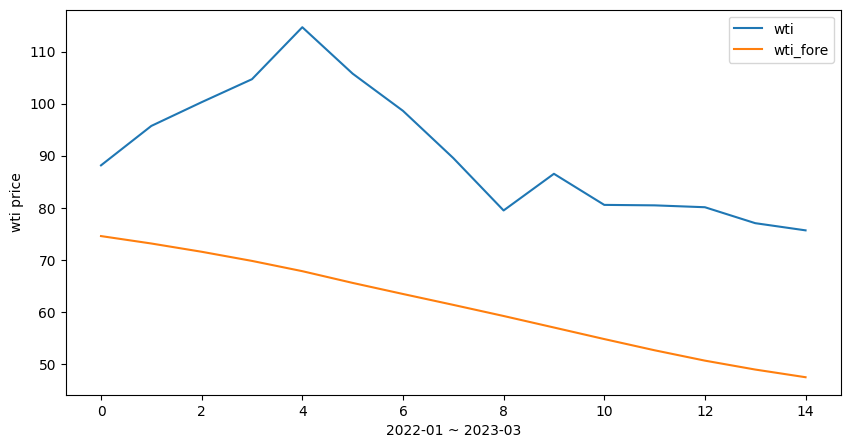

In [23]:
compare = pd.merge(actual2, pred1, left_index=True, right_index=True, how='left')

compare[['wti', 'wti_fore']].plot(figsize=(10, 5))

plt.ylabel('wti price')
plt.xlabel('2022-01 ~ 2023-03')

2-3) Performance : accuracy rate is 67.8% which is lower than 84.5% of ARIMA model

In [24]:
mse = mean_squared_error(actual1['wti'].values, pred1['wti_fore'].values, squared=False)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual1['wti'].values, pred1['wti_fore'].values)
print('MAE: '+str(mae))
mape = np.mean(np.abs(actual1['wti'].values - pred1['wti_fore'].values)/np.abs(actual1['wti'].values))
print('MAPE: '+str(mape)) 
accuracy = 1 - mape 
print('Accuracy: '+str(accuracy))

MSE: 30.27289914600499
MAE: 29.28269629923503
MAPE: 0.3223828386727229
Accuracy: 0.6776171613272771


#  N-HITS

In [ ]:
!pip install pytorch_lightning
!pip install neuralforecast

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from ray import tune
from sklearn.preprocessing import StandardScaler
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.losses.pytorch import MAE
import datetime

3-1) Setup

In [50]:
cutoff_date = '2022-01-01' 
test_period = 15 ## Forecast Period
stat_feature_limit = 100 # *2
futr_feature_limit = 100# *2
hist_feature_limit = 100 # *2

In [51]:
url = "https://raw.githubusercontent.com/pangsoo/final_6114/main/finaldata.csv"
df_temp = pd.read_csv(url)

# Data Cleasing 
df_temp['dji'] = df_temp['dji'].str.replace(',', '').astype(float)

df_temp.rename(columns = {"date" : "ds"}, inplace = True)
df_temp.rename(columns={'wti':'y'},inplace=True)

df_temp['ds'] = pd.to_datetime(df_temp['ds'], format='%b-%y')

df_temp

df_temp.insert(1, 'y', df_temp.pop('y'))
df_temp.insert(1,'unique_id','A',True)
df_temp['ds'] = df_temp['ds'] + pd.offsets.MonthEnd()

df = df_temp.copy()
df = df.loc[df.ds >= '2011-01-01']
df = df.loc[df.ds <= cutoff_date]

df.reset_index(drop=True, inplace=True)

df_tgt = df.iloc[:,3:].copy()

df_tgt
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)


raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
del raw_y_set_resampled['unique_id']

df2 = raw_y_set_resampled.drop(['date'], axis = 1)

3-2) Feature shift

In [52]:
normalized_df = (df2-df2.mean())/ df2.std()
corr1 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = False))[1:stat_feature_limit]).reset_index()['index'])
# corr2 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = True))[:stat_feature_limit]).reset_index()['index'])
stat_list = corr1 # + corr2

len(stat_list)

13

In [53]:
normalized_df['y'] = normalized_df['y'].shift(test_period)
corr3 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = False))[1:futr_feature_limit]).reset_index()['index'])
# corr4 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = True))[:futr_feature_limit]).reset_index()['index'])

for i in corr3:
  if i in corr1:
    corr3.remove(i)

# for i in corr4:
#   if i in corr2:
#     corr4.remove(i)
hist_list = corr3 # + corr4

len(hist_list)

6

In [54]:
normalized_df = (df2-df2.mean())/ df2.std()

for i in normalized_df.columns:
  if i != 'y':
    normalized_df[i] = normalized_df[i].shift(test_period)

corr5 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = False))[1:hist_feature_limit]).reset_index()['index'])
# corr6 = list(pd.DataFrame((normalized_df.corr()['y'].sort_values(ascending = True))[:futr_feature_limit]).reset_index()['index'])

for i in corr5:
  if i in corr1 or i in corr3:
    corr5.remove(i)

# for i in corr6:
#   if i in corr2 or i in corr4:
#     corr6.remove(i)

futr_list = corr5 # + corr6
len(futr_list)

6

3-3) Training and Test

- date

In [55]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

In [56]:
Y_test_df_list = list(Y_test_df)
Y_test_df_list = [x for x in Y_test_df_list if x not in futr_list]
Y_test_df_list[3:3] = futr_list
Y_test_df = Y_test_df[Y_test_df_list]

Y_train_df_list = list(Y_train_df)
Y_train_df_list = [x for x in Y_train_df if x not in futr_list]
Y_train_df_list[3:3] = futr_list
Y_train_df = Y_train_df[Y_train_df_list]

- Future df generation

In [57]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])

future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)

3-4) Models and Prediction

In [58]:
if len(Y_test_df) >= 15:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    

models = [
          NHITS(input_size= 29, 
                h=horizon,                
                stat_exog_list = None,
                # gpus = 1,
                step_size = 1,
                hist_exog_list = hist_list,
                futr_exog_list = futr_list,
                n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                interpolation_mode = 'nearest',
                n_pool_kernel_size = [2, 2, 2],
                n_freq_downsample=[4, 2, 1],
                scaler_type = 'robust',
                learning_rate=1e-3,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=32,
                random_seed=42,
                max_epochs=50
               ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)

Y_hat_df = nforecast.predict(futr_df=futr_df)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

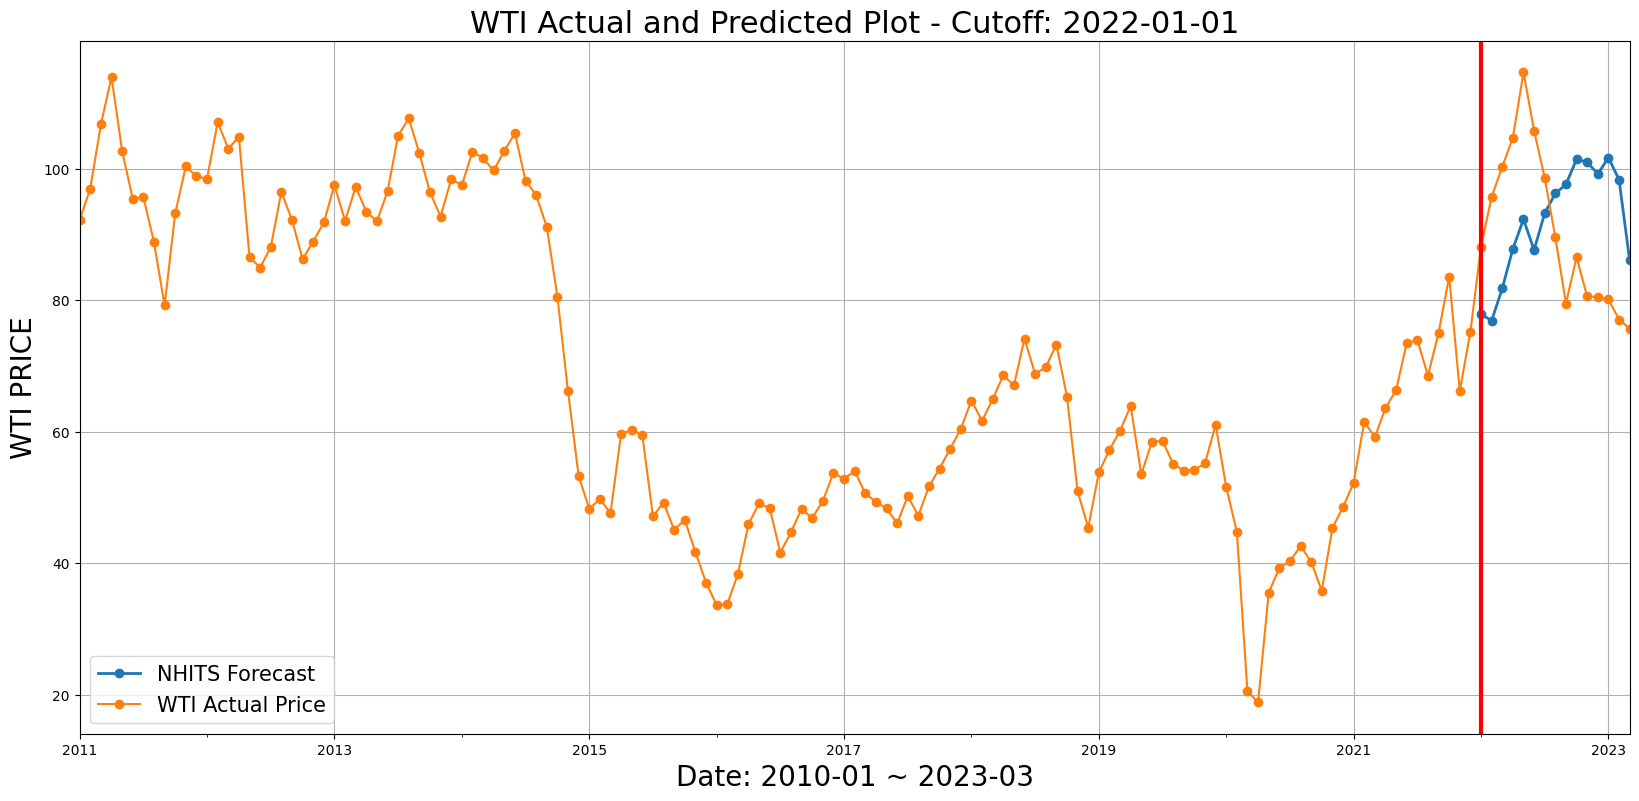

In [59]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 9))

if len(Y_test_df) > 0:
    Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
    plot_df = pd.concat([df_temp, Y_hat_df], axis = 1).set_index('ds')
else:
    plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
df_temp = df_temp.set_index('ds')
plot_df = plot_df.loc[plot_df.index >= '2019-01-31']
df_temp = df_temp.rename(columns={'y':'WTI Actual Price'})
plot_df = plot_df.rename(columns={'NHITS':'NHITS Forecast'})
plot_df[['NHITS Forecast']].plot(ax=ax, linewidth=2, marker='o')
df_temp[['WTI Actual Price']].plot(ax=ax, marker = 'o')
plt.axvline(cutoff_date, color='red',linewidth=3)
ax.set_title(f'WTI Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('WTI PRICE', fontsize=20)
ax.set_xlabel('Date: 2011-01 ~ 2023-03', fontsize=20)
# ax.set_xlim([datetime.date(2010, 1, 1), datetime.date(2023, 03, 01)])
ax.legend(prop={'size': 15})
ax.grid()

In [66]:
forecast = plot_df['NHITS Forecast']
forecast1 = forecast['2022-01-31':]
forecast1

ds
2022-01-31     77.888298
2022-02-28     76.877121
2022-03-31     81.781868
2022-04-30     87.797272
2022-05-31     92.299942
2022-06-30     87.629593
2022-07-31     93.233826
2022-08-31     96.234589
2022-09-30     97.607719
2022-10-31    101.441025
2022-11-30    100.974998
2022-12-31     99.201134
2023-01-31    101.674538
2023-02-28     98.331573
2023-03-31     86.043396
Name: NHITS Forecast, dtype: float64

In [ ]:
df_temp_wti = df_temp['WTI Actual Price']['2022-01-31':]

In [77]:
import pandas as pd
compare_nhits = pd.concat([forecast1, df_temp_wti], axis=1)
compare_nhits

,NHITS Forecast,WTI Actual Price
ds,,
2022-01-31,77.888298,88.15
2022-02-28,76.877121,95.72
2022-03-31,81.781868,100.28
2022-04-30,87.797272,104.69
2022-05-31,92.299942,114.67
2022-06-30,87.629593,105.76
2022-07-31,93.233826,98.62
2022-08-31,96.234589,89.55
2022-09-30,97.607719,79.49


3-5) Performance : Accuracy reads at 81.8%, highest among three models

In [81]:
mse = mean_squared_error(compare_nhits['WTI Actual Price'].values, compare_nhits['NHITS Forecast'].values, squared=False)
print('MSE: '+str(mse))
mae = mean_absolute_error(compare_nhits['WTI Actual Price'].values, compare_nhits['NHITS Forecast'].values)
print('MAE: '+str(mae))
mape = np.mean(np.abs(compare_nhits['WTI Actual Price'].values - compare_nhits['NHITS Forecast'].values)/np.abs(compare_nhits['WTI Actual Price'].values))
print('MAPE: '+str(mape)) 
accuracy = 1 - mape 
print('Accuracy: '+str(accuracy))

MSE: 16.998995025540353
MAE: 16.164070190429687
MAPE: 0.18158495422733753
Accuracy: 0.8184150457726624
